# Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

# To make this notebook's output stable across runs
import numpy as np
np.random.seed(42)

# Projection

PCA (section on page 222)

In [2]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles) / 2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

Principal Components (section and code on page 223)

In [3]:
X_centered = X - X.mean(axis = 0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [4]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [5]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

Projecting Down to d Dimensions (section and code on page 224)

In [6]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [7]:
X2D_using_svd = X2D

Using Scikit-Learn (section and code on page 224)

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [9]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [10]:
# See page 223 for a discussion of why the manual calculation and Scikit-Learn differ by a sign
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

In [11]:
np.allclose(X2D, -X2D_using_svd)

True

In [12]:
X3D_inv = pca.inverse_transform(X2D)

In [13]:
np.allclose(X3D_inv, X)

False

In [14]:
np.mean(np.sum(np.square(X3D_inv - X), axis = 1))

0.01017033779284855

In [15]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

In [16]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

In [17]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [18]:
# See page 223 for a discussion of why the manual calculation and Scikit-Learn differ by a sign
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

Explained Variance Ratio (section and code on page 225)

In [19]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

In [20]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

In [21]:
np.square(s) / np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

In [22]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs
        
    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)

Express the plane as a function of x and y

In [23]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 100)
x2s = np.linspace(axes[2], axes[3], 100)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

Plot the 3D dataset, the plane and the projections on that plane

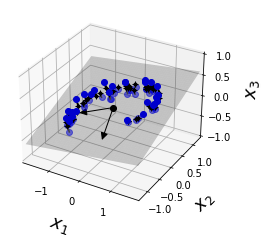

In [24]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (6.0, 3.8))
ax = fig.add_subplot(111, projection = '3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], color = 'blue', marker = 'o', linestyle = 'None', alpha = 0.5)

ax.plot_surface(x1, x2, z, alpha = 0.2, color = 'black')
np.linalg.norm(C, axis = 0)
ax.add_artist(Arrow3D([0, C[0, 0]], [0, C[0, 1]], [0, C[0, 2]], mutation_scale = 15, linewidth = 1, arrowstyle = '-|>', color = 'black'))
ax.add_artist(Arrow3D([0, C[1, 0]], [0, C[1, 1]], [0, C[1, 2]], mutation_scale = 15, linewidth = 1, arrowstyle = '-|>', color = 'black'))
ax.plot([0], [0], [0], color = 'black', marker = 'o')

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], linestyle = 'solid', color = 'black')
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], linestyle = 'solid', color = '#505050')

ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel('$x_{1}$', fontsize = 18, labelpad = 10)
ax.set_ylabel('$x_{2}$', fontsize = 18, labelpad = 10)
ax.set_zlabel('$x_{3}$', fontsize = 18, labelpad = 10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
        
plt.show()

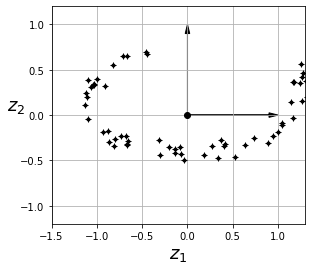

In [25]:
fig, ax = plt.subplots()
ax.set_aspect('equal')

ax.plot(X2D[:, 0], X2D[:, 1], 'k+')
ax.plot(X2D[:, 0], X2D[:, 1], 'k.')
ax.plot([0], [0], 'ko')
ax.arrow(0, 0, 0, 1, head_width = 0.05, length_includes_head = True, head_length = 0.1, fc = 'k', ec = 'k')
ax.arrow(0, 0, 1, 0, head_width = 0.05, length_includes_head = True, head_length = 0.1, fc = 'k', ec = 'k')
ax.set_xlabel('$z_{1}$', fontsize = 18)
ax.set_ylabel('$z_{2}$', fontsize = 18, rotation = 0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)

In [26]:
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples = 1000, noise = 0.2, random_state = 42)

(-12.0, 15.0)

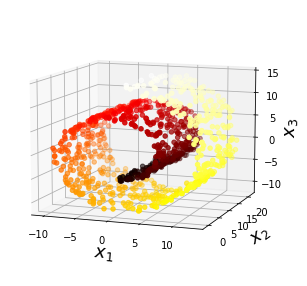

In [27]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize = (6, 5))
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c = t, cmap = plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel('$x_{1}$', fontsize = 18)
ax.set_ylabel('$x_{2}$', fontsize = 18)
ax.set_zlabel('$x_{3}$', fontsize = 18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

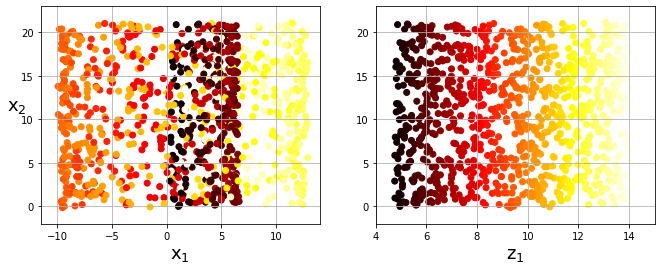

In [28]:
fig, ax = plt.subplots(ncols = 2, figsize = (11, 4))

ax[0].scatter(X[:, 0], X[:, 1], c = t, cmap = plt.cm.hot)
ax[0].axis(axes[:4])
ax[0].set_xlabel('x$_{1}$', fontsize = 18)
ax[0].set_ylabel('x$_{2}$', fontsize = 18, rotation = 0)
ax[0].grid(True)

ax[1].scatter(t, X[:, 1], c = t, cmap = plt.cm.hot)
ax[1].axis([4, 15, axes[2], axes[3]])
ax[1].set_xlabel('z$_{1}$', fontsize = 18)
ax[1].grid(True)

# Manifold Learning

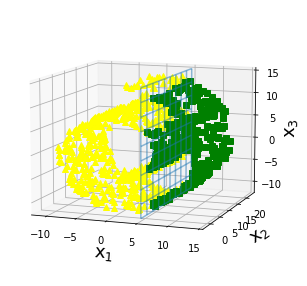

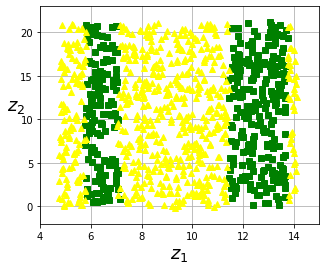

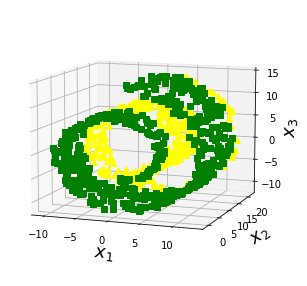

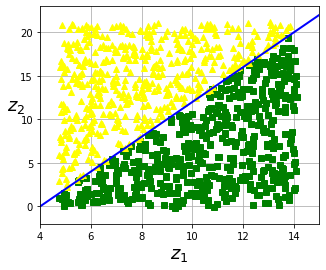

In [29]:
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize = (6, 5))
ax = plt.subplot(111, projection = '3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], color = 'yellow', marker = '^', linestyle = 'None')
ax.plot_wireframe(5, x2, x3, alpha = 0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], color = 'green', marker = 's', linestyle = 'None')
ax.set_xlabel('x$_{1}$', fontsize = 18)
ax.set_ylabel('x$_{2}$', fontsize = 18)
ax.set_zlabel('x$_{3}$', fontsize = 18)
ax.set_xlim(axes[0:2])
ax.set_xlim(axes[2:4])
ax.set_xlim(axes[4:6])

plt.show()

fig = plt.figure(figsize = (5, 4))
ax = plt.subplot(111)

ax.plot(t[positive_class], X[positive_class, 1], color = 'green', marker = 's', linestyle = 'None')
ax.plot(t[~positive_class], X[~positive_class, 1], color = 'yellow', marker = '^', linestyle = 'None')
ax.axis([4, 15, axes[2], axes[3]])
ax.set_xlabel('$z_{1}$', fontsize = 18)
ax.set_ylabel('$z_{2}$', fontsize = 18, rotation = 0)
ax.grid(True)

plt.show()

fig = plt.figure(figsize = (6, 5))
ax = plt.subplot(111, projection = '3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], color = 'yellow', marker = '^', linestyle = 'None')
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], color = 'green', marker = 's', linestyle = 'None')
ax.set_xlabel('$x_{1}$', fontsize = 18)
ax.set_ylabel('$x_{2}$', fontsize = 18)
ax.set_zlabel('$x_{3}$', fontsize = 18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

fig = plt.figure(figsize = (5, 4))
ax = plt.subplot(111)

ax.plot(t[positive_class], X[positive_class, 1], color = 'green', marker = 's', linestyle = 'None')
ax.plot(t[~positive_class], X[~positive_class, 1], color = 'yellow', marker = '^', linestyle = 'None')
ax.plot([4, 15], [0, 22], color = 'blue', linestyle = 'solid', linewidth = 2)
ax.axis([4, 15, axes[2], axes[3]])
ax.set_xlabel('$z_1$', fontsize = 18)
ax.set_ylabel('$z_2$', fontsize = 18, rotation = 0)
ax.grid(True)

plt.show()

# Preserving the Variance

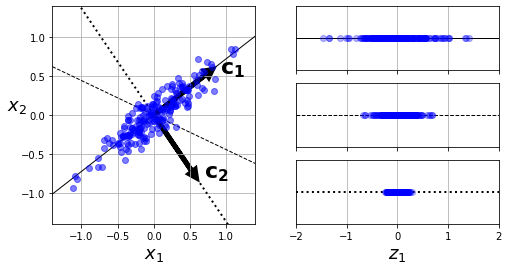

In [30]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0], [0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi / 6), np.sin(angle - 2 * np.pi / 6)])
u3 = np.array([np.cos(angle - np.pi / 2), np.sin(angle - np.pi / 2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

fig = plt.figure(figsize = (8,4))
ax = plt.subplot2grid((3, 2), (0, 0), rowspan = 3)
ax.plot([-1.4, 1.4], [-1.4 * u1[1] / u1[0], 1.4 * u1[1] / u1[0]], color = 'black', linestyle = 'solid', linewidth = 1)
ax.plot([-1.4, 1.4], [-1.4 * u2[1] / u2[0], 1.4 * u2[1] / u2[0]], color = 'black', linestyle = 'dashed', linewidth = 1)
ax.plot([-1.4, 1.4], [-1.4 * u3[1] / u3[0], 1.4 * u3[1] / u3[0]], color = 'black', linestyle = 'dotted', linewidth = 2)
ax.plot(X[:, 0], X[:, 1], color = 'blue', marker = 'o', linestyle = 'None', alpha = 0.5)
ax.axis([-1.4, 1.4, -1.4, 1.4])
ax.arrow(0, 0, u1[0], u1[1], head_width = 0.1, linewidth = 5, length_includes_head = True, head_length = 0.1, fc = 'k', ec = 'k')
ax.arrow(0, 0, u3[0], u3[1], head_width = 0.1, linewidth = 5, length_includes_head = True, head_length = 0.1, fc = 'k', ec = 'k')
ax.text(u1[0] + 0.1, u1[1] - 0.05, r'$\mathbf{c_1}$', fontsize = 22)
ax.text(u3[0] + 0.1, u3[1], r'$\mathbf{c_2}$', fontsize = 22)
ax.set_xlabel('$x_{1}$', fontsize = 18)
ax.set_ylabel('$x_{2}$', fontsize = 18, rotation = 0)
ax.grid(True)

ax = plt.subplot2grid((3,2), (0, 1))
ax.plot([-2, 2], [0, 0], color = 'black', linestyle = 'solid', linewidth = 1)
ax.plot(X_proj1[:, 0], np.zeros(m), color = 'blue', marker = 'o', linestyle = 'None', alpha = 0.3)
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticklabels([])
ax.axis([-2, 2, -1, 1])
ax.grid(True)

ax = plt.subplot2grid((3,2), (1, 1))
ax.plot([-2, 2], [0, 0], color = 'black', linestyle = 'dashed', linewidth = 1)
ax.plot(X_proj2[:, 0], np.zeros(m), color = 'blue', marker = 'o', linestyle = 'None', alpha = 0.3)
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticklabels([])
ax.axis([-2, 2, -1, 1])
ax.grid(True)

ax = plt.subplot2grid((3,2), (2, 1))
ax.plot([-2, 2], [0, 0], color = 'black', linestyle = 'dotted', linewidth = 2)
ax.plot(X_proj3[:, 0], np.zeros(m), color = 'blue', marker = 'o', linestyle = 'None', alpha = 0.3)
ax.get_yaxis().set_ticks([])
ax.axis([-2, 2, -1, 1])
ax.set_xlabel('$z_{1}$', fontsize = 18)
ax.grid(True)

plt.show()

# Choosing the Right Number of Dimensions

In [31]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version = 1, as_frame = False)
mnist.target = mnist.target.astype(np.uint8)

In [32]:
from sklearn.model_selection import train_test_split

X = mnist['data']
y = mnist['target']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [33]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [34]:
d

154

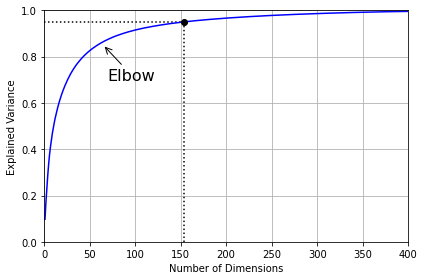

In [35]:
fig, axes = plt.subplots()
#axes.plot(cumsum, color = 'blue')
#axes.plot(np.arange(1, len(cumsum) + 1), cumsum, color = 'blue')
axes.plot(list(range(1, len(cumsum) + 1)), cumsum, color = 'blue')
axes.set_xlim([0, 400])
axes.set_ylim([0, 1])
#axes.set_xlim(150, 158)
#axes.set_ylim(0.948, 0.952)
axes.set_ylabel('Explained Variance')
axes.set_xlabel('Number of Dimensions')
axes.plot(d, 0.95, color = 'black', marker = 'o')
axes.hlines(y = 0.95, xmin = 0, xmax = d, color = 'black', linestyle = 'dotted')
axes.vlines(x = d, ymin = 0, ymax = 0.95, color = 'black', linestyle = 'dotted')
axes.annotate(text = 'Elbow', xy = (65, 0.85), xytext = (70, 0.7),
              arrowprops = dict(arrowstyle = '->'), fontsize = 16)
axes.grid(True)
fig.tight_layout()
plt.show()

In [36]:
pca = PCA(n_components = 0.95)
X_reduced = pca.fit_transform(X_train)

In [37]:
X_reduced.shape

(52500, 154)

In [38]:
X_reduced.shape[1] == d

True

In [39]:
pca.n_components_

154

In [40]:
np.sum(pca.explained_variance_ratio_)

0.9504334914295707

# PCA for Compression

In [41]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

print(X_train.shape)
print(X_reduced.shape)
print(X_recovered.shape)

(52500, 784)
(52500, 154)
(52500, 784)


In [42]:
# Using author's function instead of the one I made in an earlier chapter
def plot_digits(axes, instances, images_per_row = 5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1
    
    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis = 0)
    
    # Reshape the array so it's organized as a grid containing 28x28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))
    
    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    axes.imshow(big_image, cmap = plt.cm.binary, **options)
    axes.axis('off')

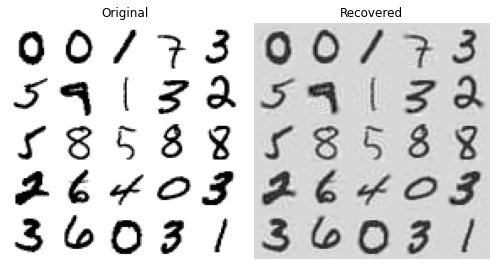

In [43]:
fig, axes = plt.subplots(ncols = 2, figsize = (7, 4))
plot_digits(axes[0], X_train[::2100])
axes[0].set_title('Original')
plot_digits(axes[1], X_recovered[::2100])
axes[1].set_title('Recovered')
fig.tight_layout()
plt.show()

In [44]:
X_reduced_pca = X_reduced

# Randomized PCA

In [45]:
rnd_pca = PCA(n_components = 154, svd_solver = 'randomized', random_state = 42)
X_reduced = rnd_pca.fit_transform(X_train)

# Incremental PCA

In [46]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components = 154)
for X_batch in np.array_split(X_train, n_batches):
    print('.', end = '')
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [47]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

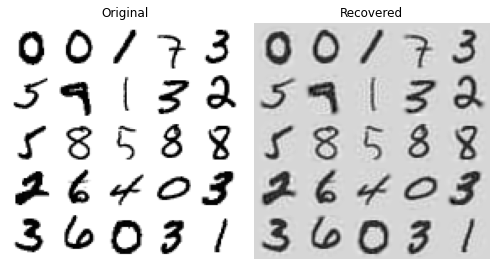

In [48]:
fig, axes = plt.subplots(ncols = 2, figsize = (7, 4))
plot_digits(axes[0], X_train[::2100])
axes[0].set_title('Original')
plot_digits(axes[1], X_recovered_inc_pca[::2100])
axes[1].set_title('Recovered')
fig.tight_layout()
plt.show()

In [49]:
X_reduced_inc_pca = X_reduced

In [50]:
np.allclose(pca.mean_, inc_pca.mean_)

True

In [51]:
np.allclose(X_reduced_pca, X_reduced_inc_pca)

False

Using `memmap()`:

In [52]:
filename = 'my_mnist.data'
m, n = X_train.shape

X_mm = np.memmap(filename, dtype = 'float32', mode = 'write', shape = (m, n))
X_mm[:] = X_train

In [53]:
del X_mm

In [54]:
X_mm = np.memmap(filename, dtype = 'float32', mode = 'readonly', shape = (m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components = 154, batch_size = batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, n_components=154)

Time complexity

In [55]:
import time

for n_components in (2, 10, 154):
    print('n_components =', n_components)
    regular_pca = PCA(n_components = n_components, svd_solver = 'full')
    inc_pca = IncrementalPCA(n_components = n_components, batch_size = 500)
    rnd_pca = PCA(n_components = n_components, random_state = 42, svd_solver = 'randomized')
    
    for name, pca in (('PCA', regular_pca), ('Incremental PCA', inc_pca), ('Rnd PCA', rnd_pca)):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print(f'     {name}: {t2 - t1:.1f} seconds')

n_components = 2
     PCA: 4.5 seconds
     Incremental PCA: 8.0 seconds
     Rnd PCA: 1.8 seconds
n_components = 10
     PCA: 4.5 seconds
     Incremental PCA: 8.2 seconds
     Rnd PCA: 1.9 seconds
n_components = 154
     PCA: 4.5 seconds
     Incremental PCA: 11.2 seconds
     Rnd PCA: 3.2 seconds


In [56]:
times_rpca = []
times_pca = []
sizes = [1e3, 1e4, 2e4, 3e4, 4e4, 5e4, 7e4, 1e5, 2e5, 5e5]
for n_samples in sizes:
    X = np.random.randn(int(n_samples), 5)
    
    pca = PCA(n_components = 2, svd_solver = 'randomized', random_state = 42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    
    pca = PCA(n_components = 2, svd_solver = 'full')
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

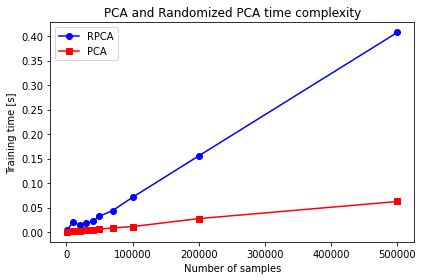

In [57]:
fig, axes = plt.subplots()
axes.plot(sizes, times_rpca, color = 'blue', marker = 'o', label = 'RPCA')
axes.plot(sizes, times_pca, color = 'red', marker = 's', label = 'PCA')
axes.set_xlabel('Number of samples')
axes.set_ylabel('Training time [s]')
axes.set_title('PCA and Randomized PCA time complexity')
axes.legend()
fig.tight_layout()
plt.show()

In [58]:
times_rpca = []
times_pca = []
sizes = [1e3, 2e3, 3e3, 4e3, 5e3, 6e3]
for n_features in sizes:
    X = np.random.randn(2000, int(n_features))
    
    pca = PCA(n_components = 2, svd_solver = 'randomized', random_state = 42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    
    pca = PCA(n_components = 2, svd_solver = 'full')
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

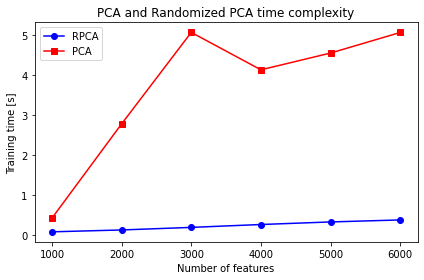

In [59]:
fig, axes = plt.subplots()
axes.plot(sizes, times_rpca, color = 'blue', marker = 'o', label = 'RPCA')
axes.plot(sizes, times_pca, color = 'red', marker = 's', label = 'PCA')
axes.set_xlabel('Number of features')
axes.set_ylabel('Training time [s]')
axes.set_title('PCA and Randomized PCA time complexity')
axes.legend()
fig.tight_layout()
plt.show()

# Kernel PCA

In [60]:
X, t = make_swiss_roll(n_samples = 1000, noise = 0.2, random_state = 42)

In [61]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel = 'rbf', gamma = 0.04)
X_reduced = rbf_pca.fit_transform(X)

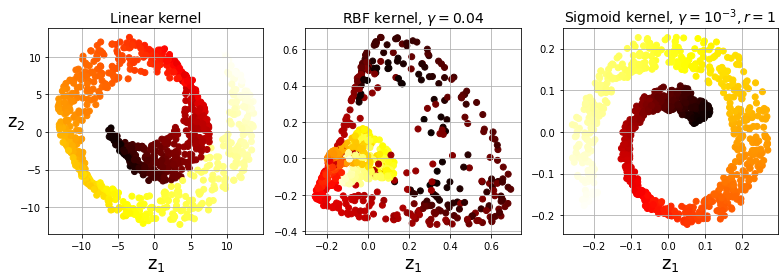

In [62]:
lin_pca = KernelPCA(n_components = 2, kernel = 'linear', fit_inverse_transform = True)
rbf_pca = KernelPCA(n_components = 2, kernel = 'rbf', gamma = 0.0433, fit_inverse_transform = True)
sig_pca = KernelPCA(n_components = 2, kernel = 'sigmoid', gamma = 0.001, coef0 = 1, fit_inverse_transform = True)

y = t > 6.9

fig, axes = plt.subplots(ncols = 3, figsize = (11, 4))
for index, pca, title in ((0, lin_pca, 'Linear kernel'), (1, rbf_pca, 'RBF kernel, $\gamma = 0.04$'), (2, sig_pca, 'Sigmoid kernel, $\gamma = 10^{-3}, r = 1$')):
    X_reduced = pca.fit_transform(X)
    if index == 1:
        X_reduced_rbf = X_reduced
        
    axes[index].set_title(title, fontsize = 14)
    axes[index].scatter(x = X_reduced[:, 0], y = X_reduced[:, 1], c = t, cmap = plt.cm.hot)
    axes[index].set_xlabel('z$_{1}$', fontsize = 18)
    if index == 0:
        axes[index].set_ylabel('z$_{2}$', fontsize = 18, rotation = 0)
    axes[index].grid(True)
    
fig.tight_layout()
plt.show()

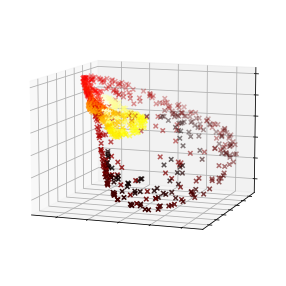

In [63]:
X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

fig = plt.figure(figsize = (6, 5))
ax = plt.subplot(111, projection = '3d')
ax.view_init(10, -70)
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c = t, cmap = plt.cm.hot, marker = 'x')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_zlabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

plt.show()

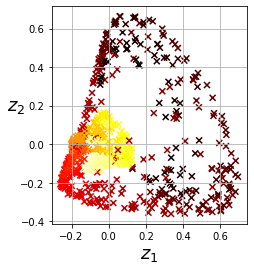

In [64]:
X_reduced = rbf_pca.fit_transform(X)

fig, axes = plt.subplots(figsize = (3.5, 4))
axes.scatter(X_reduced[:, 0], X_reduced[:, 1], c = t, cmap = plt.cm.hot, marker = 'x')
axes.set_xlabel('$z_{1}$', fontsize = 18)
axes.set_ylabel('$z_{2}$', fontsize = 18, rotation = 0)
axes.grid(True)

plt.show()

# Selecting a Kernel and Tuning Hyperparameters

In [65]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ('kpca', KernelPCA(n_components = 2)),
    ('log_reg', LogisticRegression(solver = 'lbfgs'))
])

param_grid = [{
    'kpca__gamma': np.linspace(0.03, 0.05, 10),
    'kpca__kernel': ['rbf', 'sigmoid']
}]

grid_search = GridSearchCV(clf, param_grid, cv = 3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [66]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [67]:
rbf_pca = KernelPCA(n_components = 2, kernel = 'rbf', gamma = 0.0433,
                    fit_inverse_transform = True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [68]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(X, X_preimage))

32.78630879576612


# LLE

In [69]:
X, t = make_swiss_roll(n_samples = 1000, noise = 0.2, random_state = 41)

In [70]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components = 2, n_neighbors = 10, random_state = 42)
X_reduced = lle.fit_transform(X)

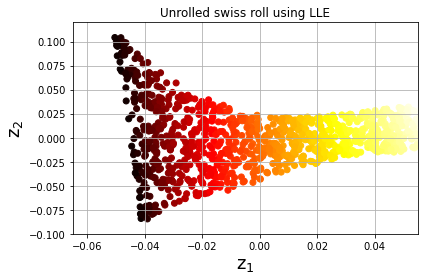

In [71]:
fig, axes = plt.subplots()
axes.scatter(X_reduced[:, 0], X_reduced[:, 1], c = t, cmap = plt.cm.hot)
axes.set_xlabel('z$_{1}$', fontsize = 18)
axes.set_ylabel('z$_{2}$', fontsize = 18)
axes.set_xlim(-0.065, 0.055)
axes.set_ylim(-0.1, 0.12)
axes.set_title('Unrolled swiss roll using LLE')
axes.grid(True)
fig.tight_layout()
plt.show()

# Other Dimensionality Reduction Techniques

In [72]:
from sklearn.manifold import MDS

mds = MDS(n_components = 2, random_state = 42)
X_reduced_mds = mds.fit_transform(X)

In [73]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components = 2)
X_reduced_isomap = isomap.fit_transform(X)

In [74]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, random_state = 42)
X_reduced_tsne = tsne.fit_transform(X)

In [75]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components = 2)
X_mnist = mnist['data']
y_mnist = mnist['target']
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

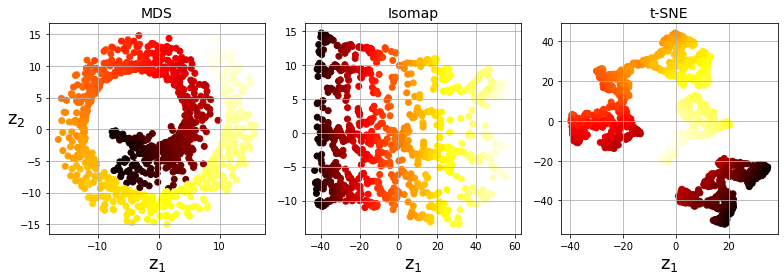

In [76]:
titles = ['MDS', 'Isomap', 't-SNE']

fig, axes = plt.subplots(ncols = 3, figsize = (11, 4))

for index, title, X_reduced in zip((0, 1, 2), titles,
                                   (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    axes[index].set_title(title, fontsize = 14)
    axes[index].scatter(X_reduced[:, 0], X_reduced[:, 1], c = t, cmap = plt.cm.hot)
    axes[index].set_xlabel('z$_{1}$', fontsize = 18)
    if index == 0:
        axes[index].set_ylabel('z$_{2}$', fontsize = 18, rotation = 0)
    axes[index].grid(True)
    
fig.tight_layout()
plt.show()

# Exercise 1

Review pages 215-216.

Advantages
- Speeds up training algorithms (in some cases, it may remove noise and redundant features, making the algorithm perform better)
- Useful for data visualization
- Saves space

Disadvantages
- Loss of information, making algorithms perform slightly worse
- Makes pipelines a bit more complex and thus harder to maintain
- Can be computationally intensive
- Transformed features can be hard to interpret

# Exercise 2

Page 215: "Many Machine Learning problems involve thousands or even millions of features for each training instance. Not only this make training extremely slow, it can also make it much harder to find a good solution."

Page 217: "... high-dimensional datasets are at risk of being very sparse: most training instances are likely to be far away from each other. Of course, this also means that a new instance will likely be far away from any training instance, making predictions much less reliable than in lower dimensions, since they will be based on much larger extrapolations. In short, the more dimensions the training set has, the greater the risk of overfitting it."

Page 217: "In theory, one solution to the curse of dimensionality could be to increase the size of the training set to reach a sufficient density of training instances. Unfortunately, in practice, the number of training instances required to reach a given density grows exponentially with the number of dimensions."

# Exercise 3

Page 216: Reducing dimensionality does lose some information.

Page 226: With dimensionality reduction, information is lost.
For example, with PCA projection, some variance is lost.
You can *partially* reverse the operation using the inverse transform of the PCA projection.
The resulting "reconstructed" or "recovered" data will be close to the original data.
However, some algorithms (such as T-SNE) do not have an inverse transform.

# Exercise 4

PCA can reduce the dimensionality of nonlinear data sets because it can get rid of useless dimensions.
However, if there are no useless dimensions (for example, the Swiss roll), then reducing dimensionality with PCA will lose too much information.
You want to unroll the Swiss roll, not squash it.

# Exercise 5

It depends on the dataset.
In this particular example, anywhere between 1 and 1000 dimensions.
Plotting the explained variance as a function of the number of dimensions (like in Figure 8-8) is one way to get a rough idea of the dataset's dimensionality.

# Exercise 6

- **Regular PCA**: The default, but only works if the dataset fits in memory (page 227).
- **Incremental PCA**: Useful for large datasets that don't fit in memory, but is slower than regular PCA (see the timed calculations earlier in this notebook). Also useful when wanting to apply PCA online (page 228).
- **Randomized PCA**: The dataset must fit in memory. Faster than regular PCA (see timed calculations earlier in this notebook). This is used when you want to considerably reduce the dimensionality.
- **Kernel PCA**: Useful for nonlinear datasets (page 228).

# Exercise 7

It performs well if it eliminates a lot of dimensions without losing too much information (equivalently, preserving the variance (page 222)).
A useful piece of information is the explained variance ratio (page 225).

One way to measure the performance is to apply the inverse transformation and look at the reconstruction error (page 226).
However, not all algorithms have an inverse transformation.

If using dimensionality reduction as a preprocessing step before another machine learning algorithm (as done on pages 229-230), then you can measure the perform of that second algorithm.
That is, compare the performance of the machine learning algorithm with the original dataset and the reduced data set (from dimensionality reduction).

# Exercise 8

Yes.
One example is using PCA for dimensionality reduction, then using a slower algorithm such as LLE (page 232).
The one-step and two-step approaches will likely perform similarly, but the two-step approach will be faster.

For an example of this, see exercise 10 of this chapter.

# Exercise 9

In [77]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version = 1, as_frame = False)
mnist.target = mnist.target.astype(np.uint8)

In [78]:
X = mnist['data']
y = mnist['target']

X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


In [79]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)

In [80]:
import time

t1 = time.time()
rnd_clf.fit(X = X_train, y = y_train)
t2 = time.time()
print(f'{t2 - t1:.1f} seconds')

36.4 seconds


In [81]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X = X_test)
print(accuracy_score(y_true = y_test, y_pred = y_pred))

0.9705


In [82]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.95)
X_train_reduced = pca.fit_transform(X = X_train)

In [83]:
t1 = time.time()
rnd_clf.fit(X = X_train_reduced, y = y_train)
t2 = time.time()
print(f'{t2 - t1:.1f} seconds')

72.4 seconds


In [84]:
X_test_reduced = pca.transform(X = X_test) # transform, not fit_transform

In [85]:
y_pred = rnd_clf.predict(X = X_test_reduced)
print(accuracy_score(y_true = y_test, y_pred = y_pred))

0.9481


With PCA, the training time is slower and the accuracy is reduced.
Dimensionality reduction does not always lead to a faster training time: it depends on the dataset, the model, and the training algorithm.
The decrease in performance is due to lose of information.

Instead of a random forest classifier, try softmax regression.

In [86]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', random_state = 42)

In [87]:
t1 = time.time()
log_clf.fit(X = X_train, y = y_train)
t2 = time.time()
print(f'{t2 - t1:.1f} seconds')

15.2 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [88]:
y_pred = log_clf.predict(X = X_test)

print(accuracy_score(y_true = y_test, y_pred = y_pred))

0.9255


Softmax regression performs worse on the training set than the random forest classifier.
But we want to see how PCA helps:

In [89]:
t1 = time.time()
log_clf.fit(X = X_train_reduced, y = y_train)
t2 = time.time()
print(f'{t2 - t1:.1f} seconds')

4.7 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [90]:
y_pred = log_clf.predict(X = X_test_reduced)

print(accuracy_score(y_true = y_test, y_pred = y_pred))

0.9201


After PCA, the training time is faster, and there is a small decrease in performance.

# Exercise 10

In [91]:
# Use a random subset of 10,000 images

np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist['data'][idx]
y = mnist['target'][idx]

In [92]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, random_state = 42)
X_reduced = tsne.fit_transform(X = X)

In [93]:
print(X.shape)
print(X_reduced.shape)

(10000, 784)
(10000, 2)


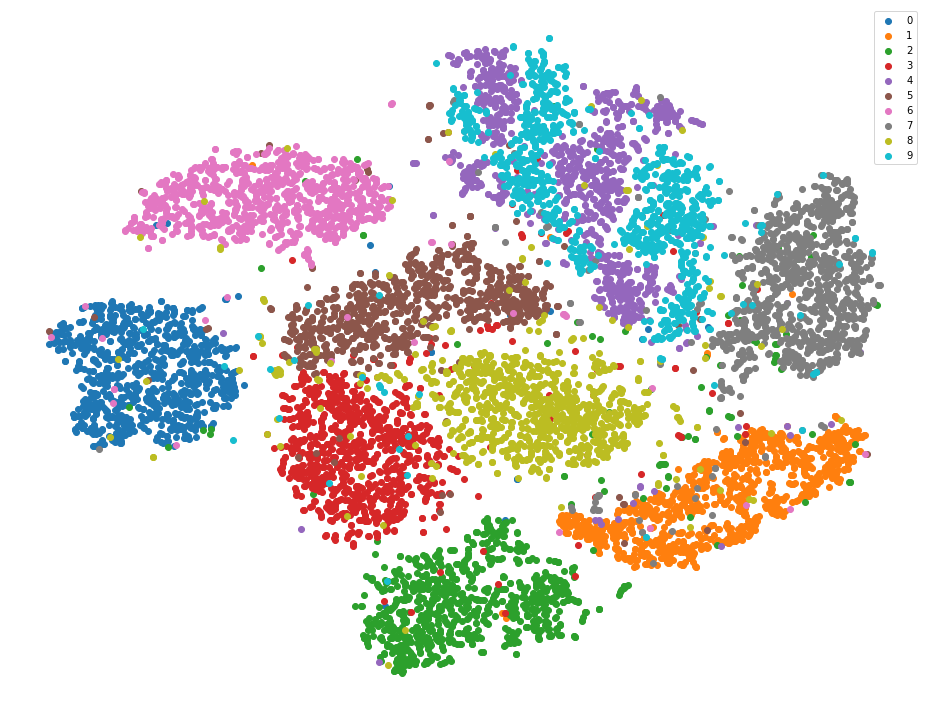

In [94]:
fig, axes = plt.subplots(figsize = (13, 10))
for digit in range(10):
    axes.scatter(x = X_reduced[:, 0][y == digit], y = X_reduced[:, 1][y == digit], label = digit)
axes.axis('off')
axes.legend()
fig.tight_layout()
plt.show()

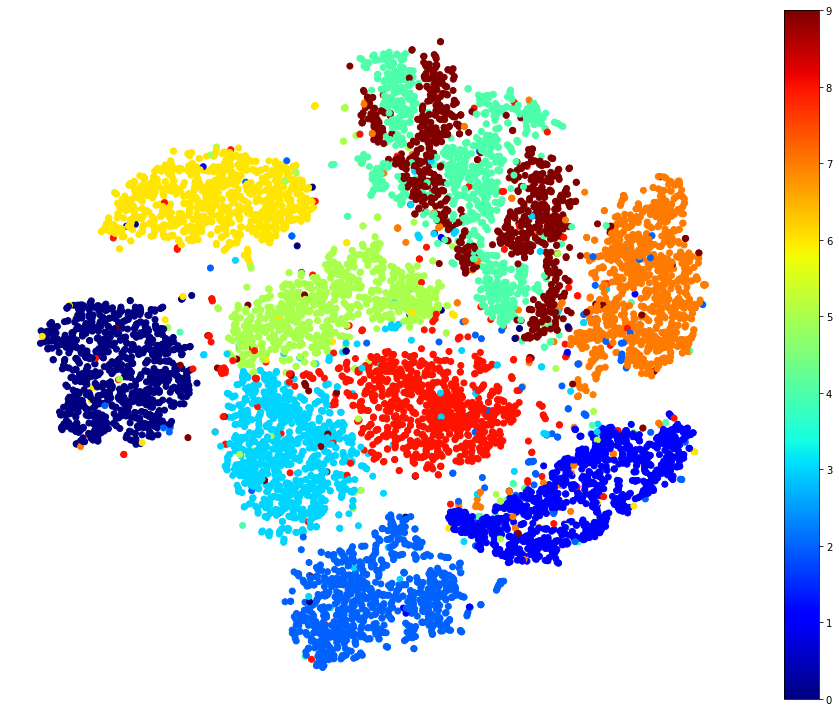

In [95]:
fig, axes = plt.subplots(figsize = (13, 10))
scatter = axes.scatter(x = X_reduced[:, 0], y = X_reduced[:, 1], c = y, cmap = 'jet')
axes.axis('off')
fig.colorbar(mappable = scatter)
fig.tight_layout()
plt.show()

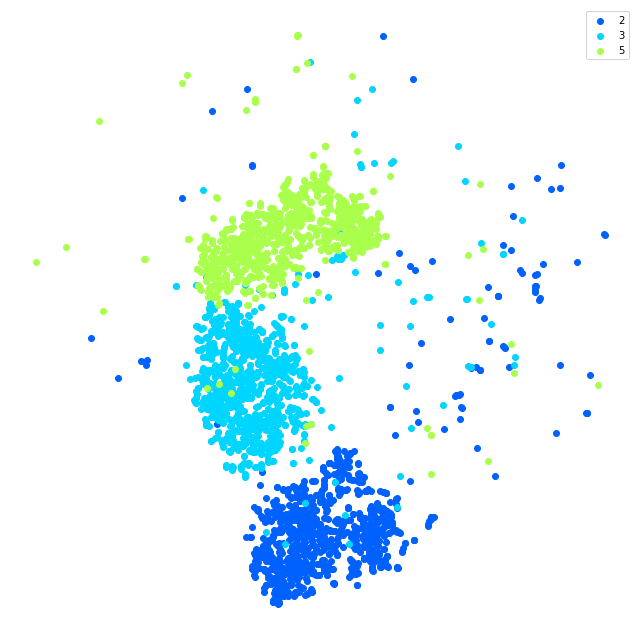

In [96]:
# Focus on digits 2, 3, and 5, which seem to overlap a lot
fig, axes = plt.subplots(figsize = (9, 9))
cmap = plt.cm.get_cmap('jet')
for digit in (2, 3, 5):
    #axes.scatter(x = X_reduced[y == digit, 0], y = X_reduced[y == digit, 1], color = cmap(digit / 9), label = digit)
    axes.scatter(x = X_reduced[y == digit, 0], y = X_reduced[y == digit, 1], c = [cmap(digit / 9)], label = digit)
axes.axis('off')
axes.legend()
fig.tight_layout()
plt.show()

In [97]:
idx = (y == 2) | (y == 3) | (y == 5)

X_subset = X[idx]
y_subset = y[idx]

tsne_subset = TSNE(n_components = 2, random_state = 42)
X_subset_reduced = tsne_subset.fit_transform(X = X_subset)

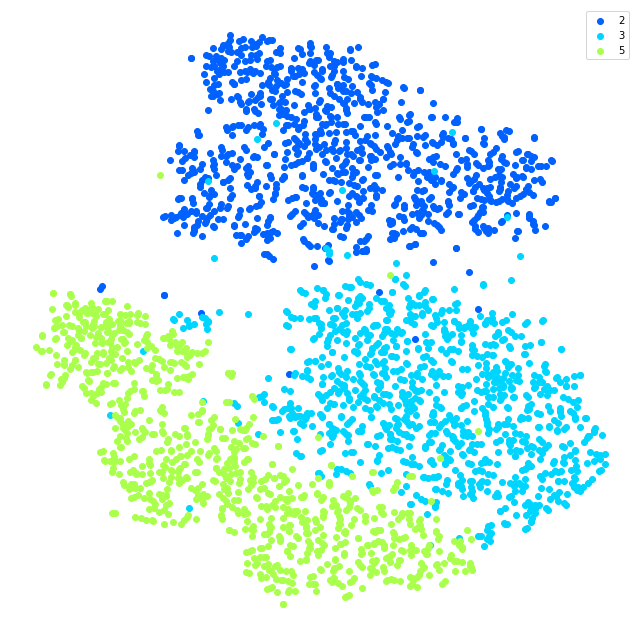

In [98]:
fig, axes = plt.subplots(figsize = (9, 9))
cmap = plt.cm.get_cmap('jet')
for digit in (2, 3, 5):
    #axes.scatter(x = X_subset_reduced[y_subset == digit, 0], y = X_subset_reduced[y_subset == digit, 1], color = cmap(digit / 9), label = digit)
    axes.scatter(x = X_subset_reduced[y_subset == digit, 0], y = X_subset_reduced[y_subset == digit, 1], c = [cmap(digit / 9)], label = digit)
axes.axis('off')
axes.legend()
fig.tight_layout()
plt.show()

In [99]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(axes, X, y, min_distance = 0.05, images = None):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    cmap = plt.cm.get_cmap('jet')
    digits = np.unique(y)
    for digit in digits:
        axes.scatter(x = X_normalized[y == digit, 0], y = X_normalized[y == digit, 1], c = [cmap(digit / 9)])
    axes.axis('off')
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis = 1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                axes.text(x = image_coord[0], y = image_coord[1], s = str(int(y[index])),
                          color = cmap(y[index] / 9), fontdict = {'weight': 'bold', 'size': 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap = 'binary'), image_coord)
                axes.add_artist(imagebox)

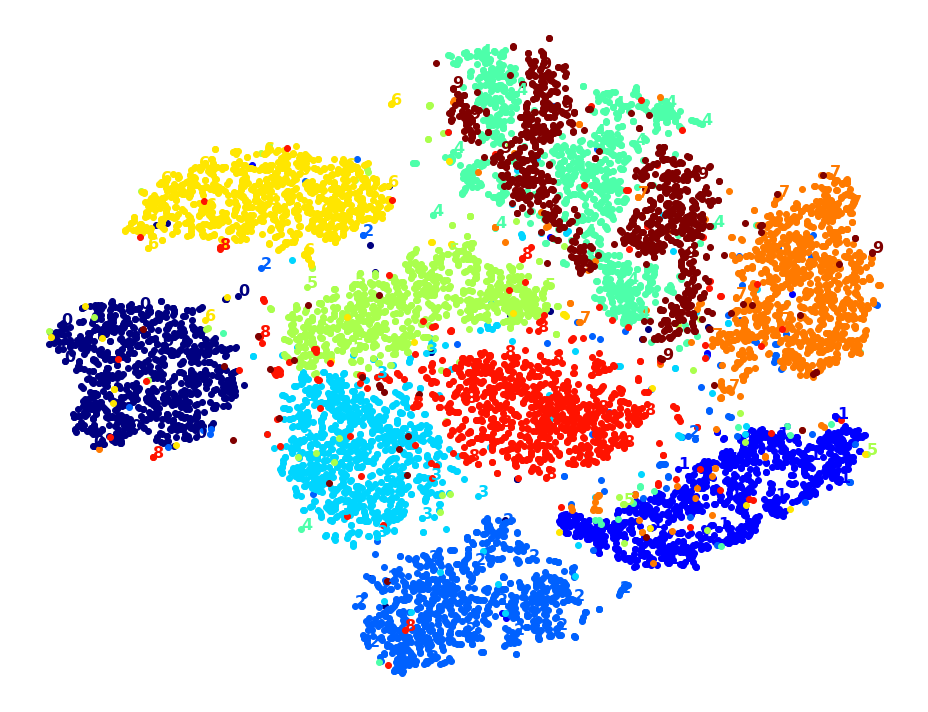

In [100]:
fig, axes = plt.subplots(figsize = (13, 10))
plot_digits(axes, X_reduced, y)
fig.tight_layout()
plt.show()

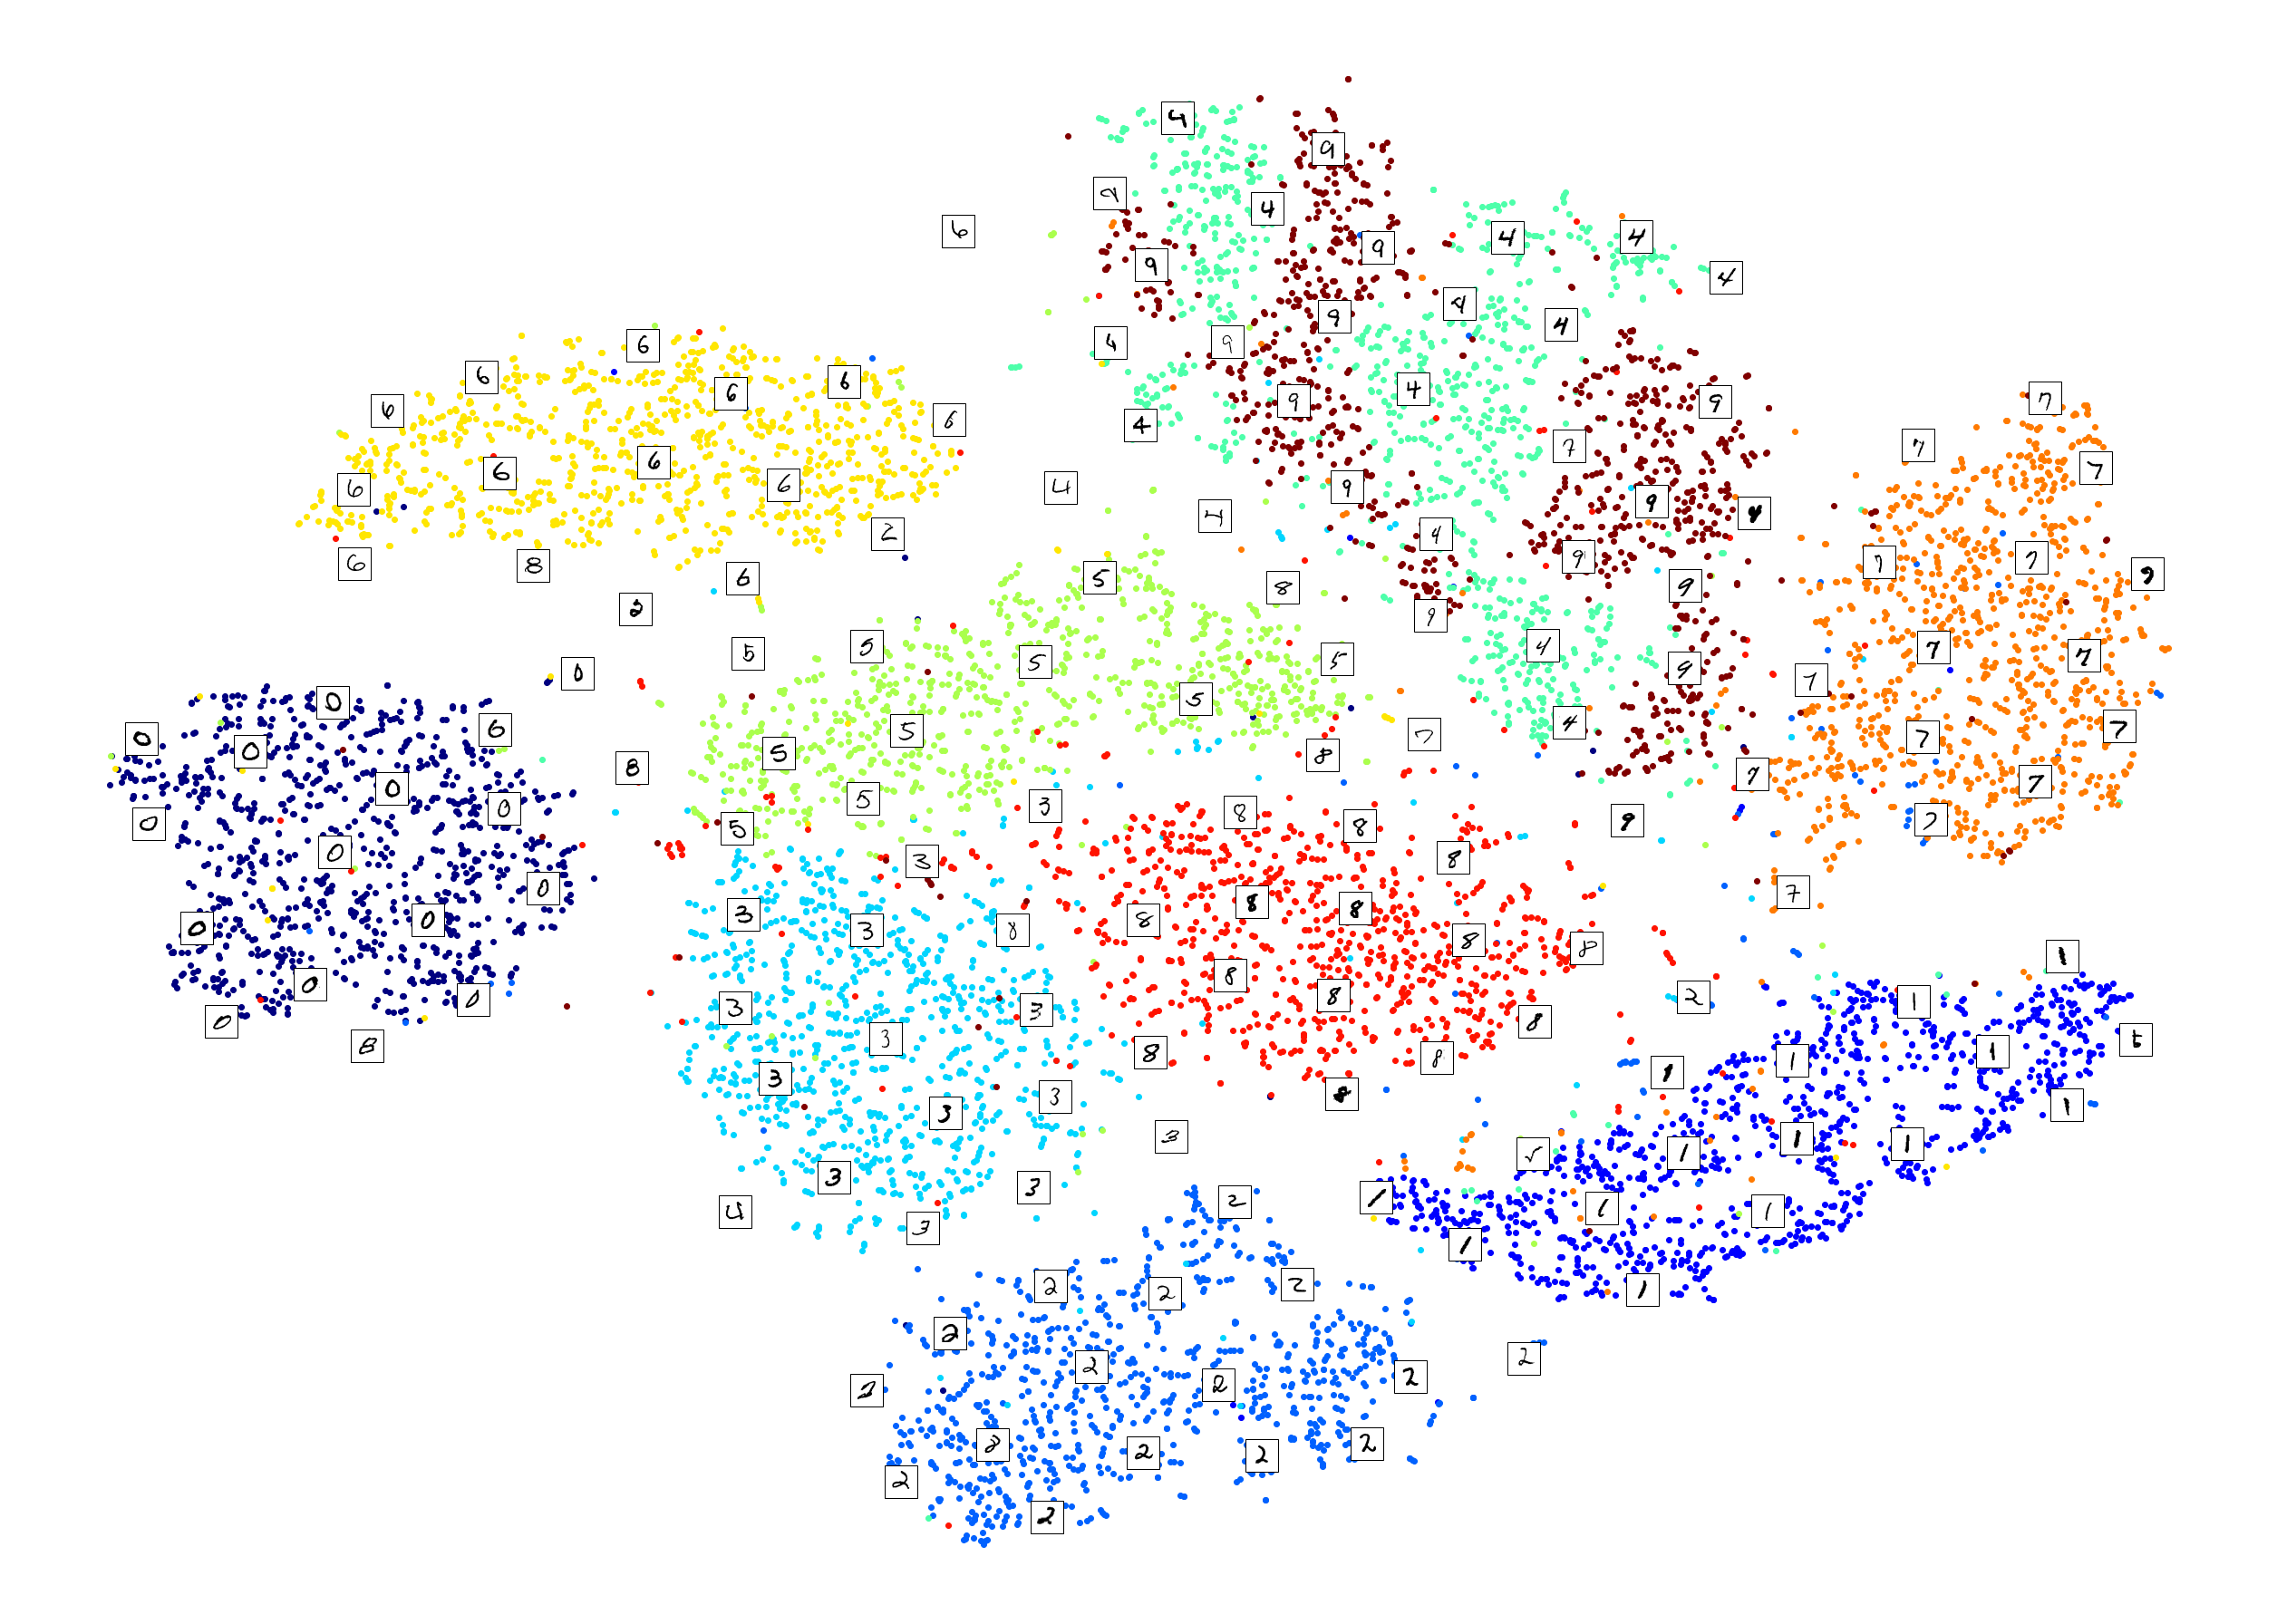

In [101]:
fig, axes = plt.subplots(figsize = (35, 25))
plot_digits(axes, X_reduced, y, images = X)
fig.tight_layout()
plt.show()

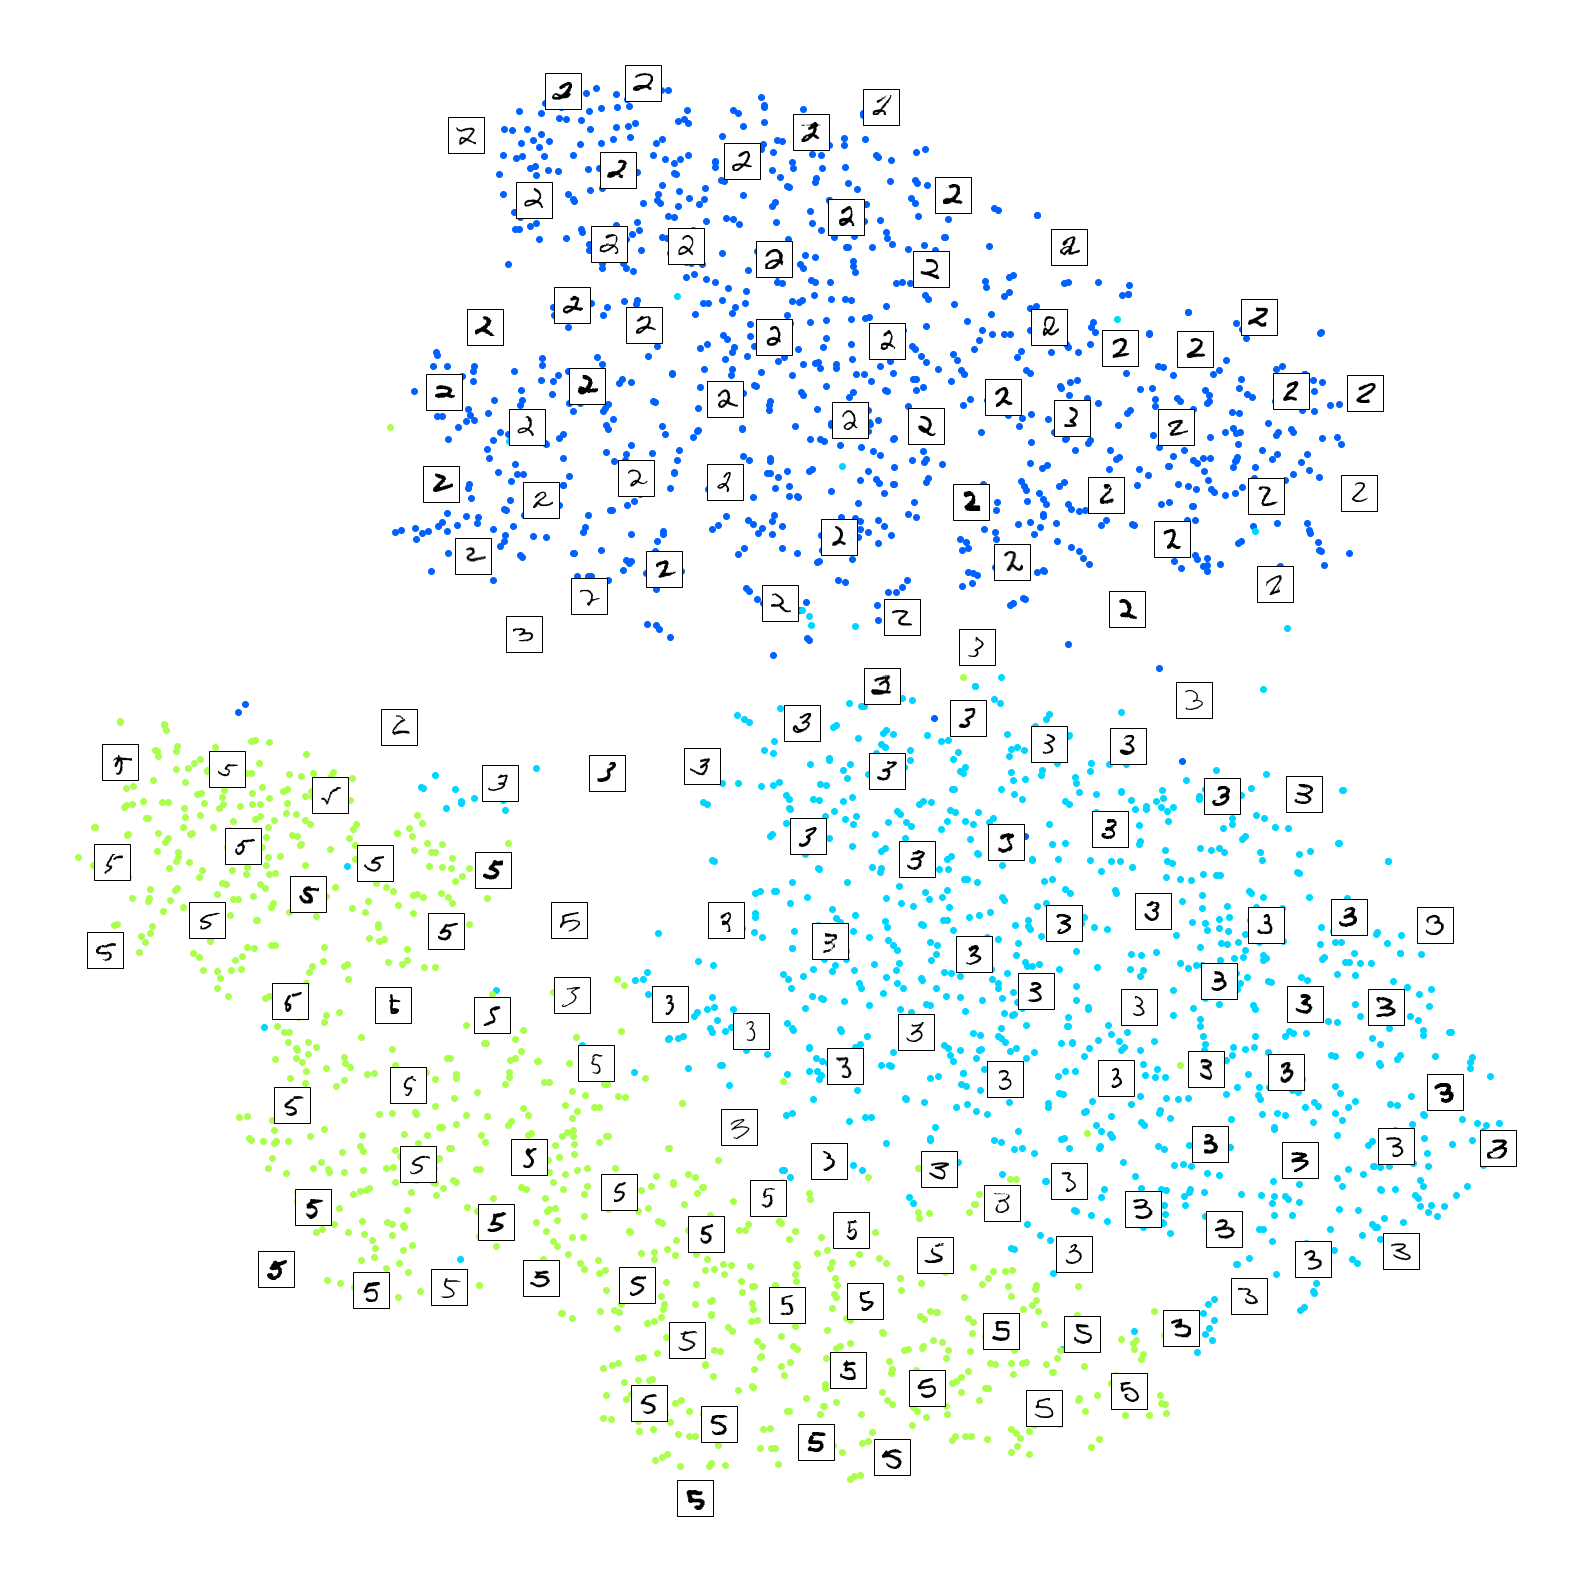

In [102]:
fig, axes = plt.subplots(figsize = (22, 22))
plot_digits(axes, X_subset_reduced, y_subset, images = X_subset)
fig.tight_layout()
plt.show()

Try using other dimensionality reduction algorithms such as PCA, LLE, or MDS and compare the resulting visualizations.

0.3 seconds


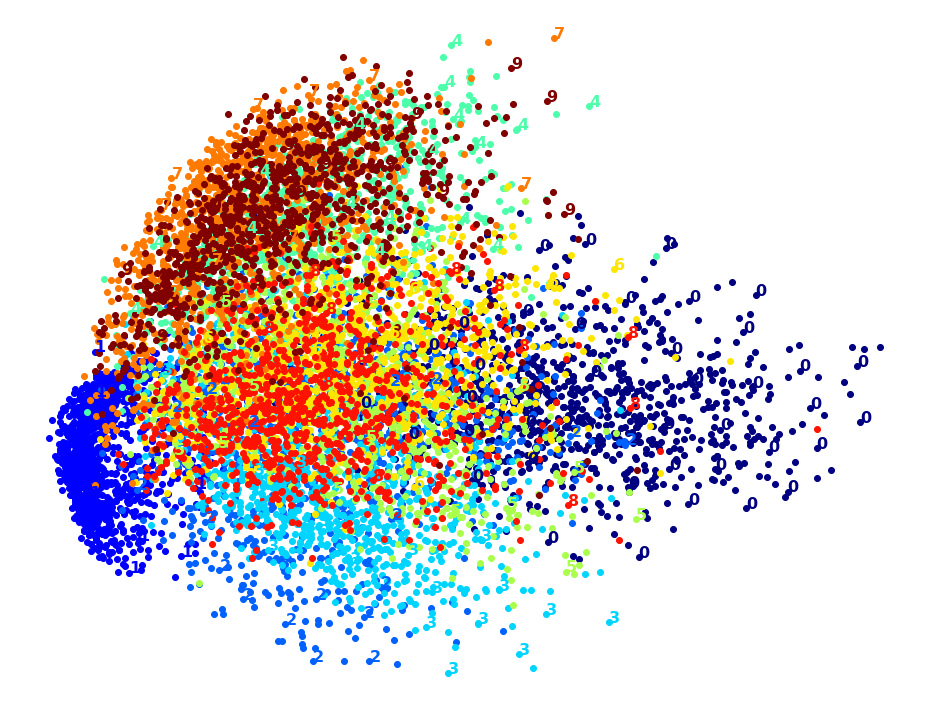

In [103]:
from sklearn.decomposition import PCA
import time

t0 = time.time()
X_pca_reduced = PCA(n_components = 2, random_state = 42).fit_transform(X = X)
t1 = time.time()
print(f'{t1 - t0:.1f} seconds')

fig, axes = plt.subplots(figsize = (13, 10))
plot_digits(axes, X_pca_reduced, y)
fig.tight_layout()
plt.show()

11.9 seconds


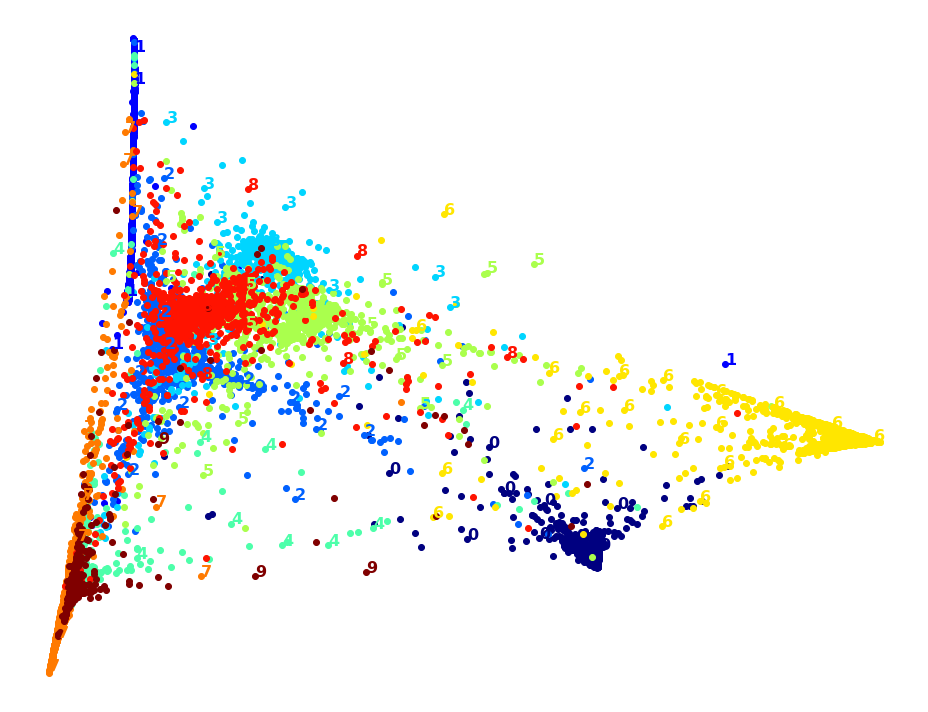

In [104]:
from sklearn.manifold import LocallyLinearEmbedding

t0 = time.time()
X_lle_reduced = LocallyLinearEmbedding(n_components = 2, random_state = 42).fit_transform(X = X)
t1 = time.time()
print(f'{t1 - t0:.1f} seconds')

fig, axes = plt.subplots(figsize = (13, 10))
plot_digits(axes, X_lle_reduced, y)
fig.tight_layout()
plt.show()

13.9 seconds


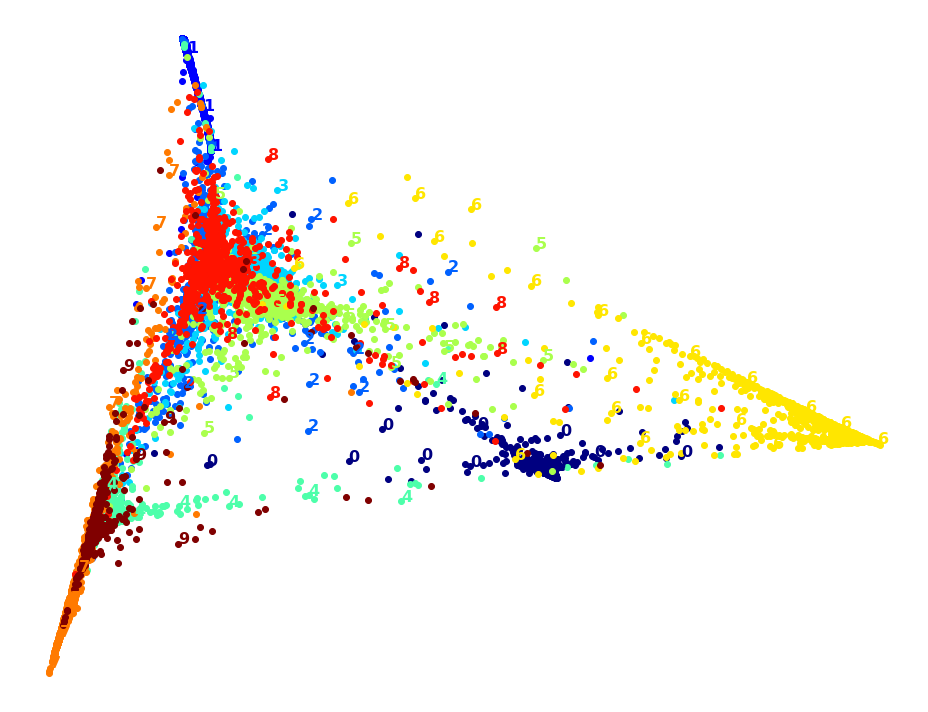

In [105]:
from sklearn.pipeline import Pipeline

pca_lle = Pipeline([
    ('pca', PCA(n_components = 0.95, random_state = 42)),
    ('lle', LocallyLinearEmbedding(n_components = 2, random_state = 42))
])

t0 = time.time()
X_pca_lle_reduced = pca_lle.fit_transform(X = X)
t1 = time.time()
print(f'{t1 - t0:.1f} seconds')

fig, axes = plt.subplots(figsize = (13, 10))
plot_digits(axes, X_pca_lle_reduced, y)
fig.tight_layout()
plt.show()

The result is more or less the same in terms of separation and running time.

119.8 seconds (on 2000 instances)


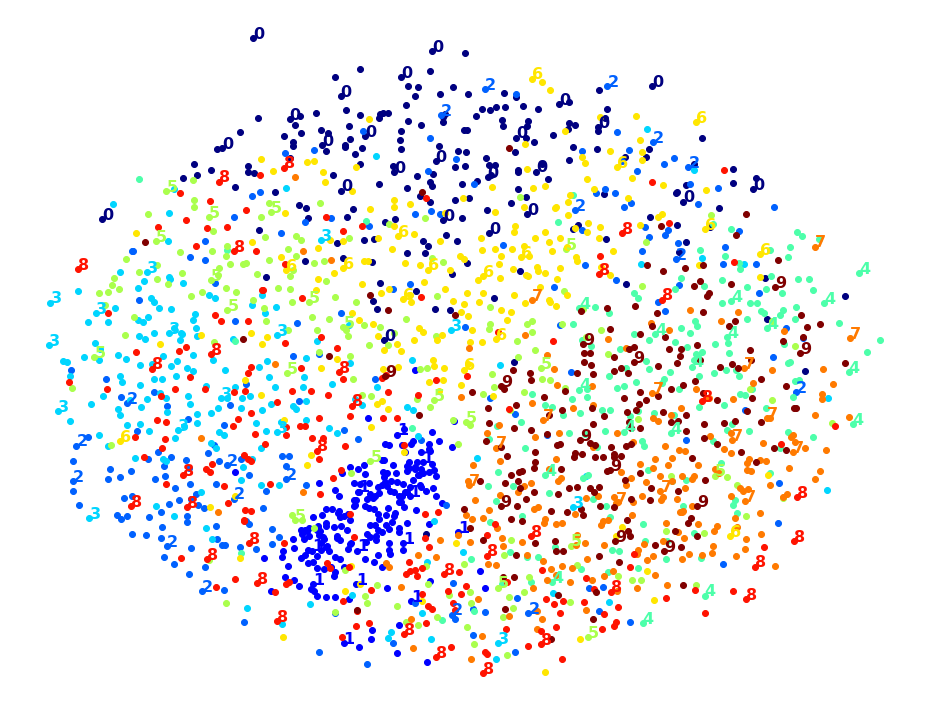

In [106]:
# Use 2000 instances
from sklearn.manifold import MDS

m = 2000
t0 = time.time()
X_mds_reduced = MDS(n_components = 2, random_state = 42).fit_transform(X[:m])
t1 = time.time()
print(f'{t1 - t0:.1f} seconds (on {m} instances)')

fig, axes = plt.subplots(figsize = (13, 10))
plot_digits(axes, X_mds_reduced, y[:m])
fig.tight_layout()
plt.show()

181.7 seconds (on 2000 instances)


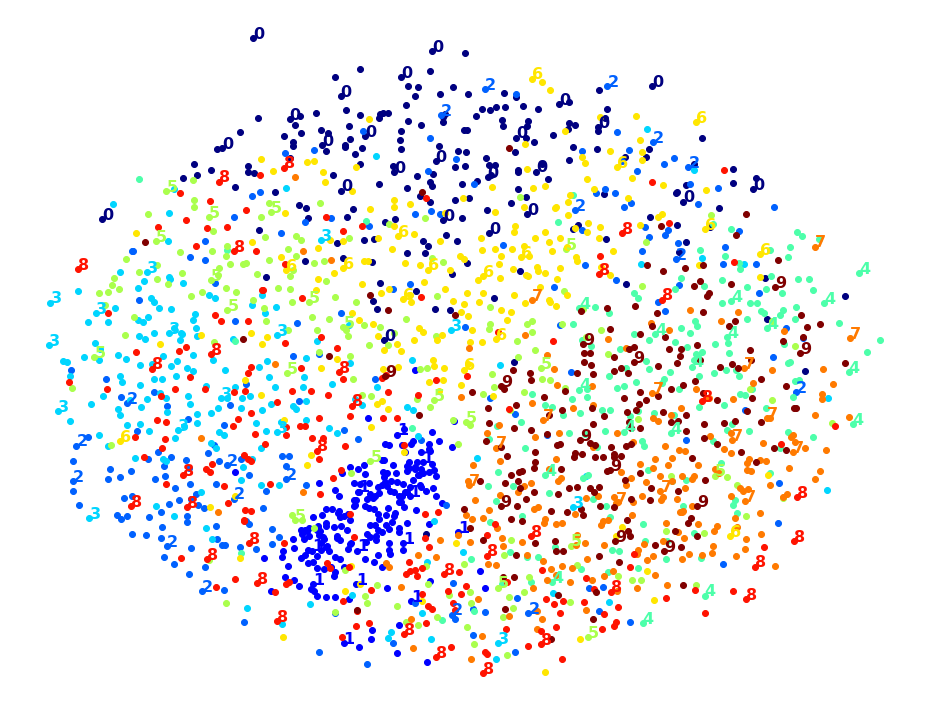

In [107]:
from sklearn.pipeline import Pipeline

pca_mds = Pipeline([
    ('pca', PCA(n_components = 0.95, random_state = 42)),
    ('mds', MDS(n_components = 2, random_state = 42))
])

t0 = time.time()
X_pca_mds_reduced = pca_mds.fit_transform(X[:m])
t1 = time.time()
print(f'{t1 - t0:.1f} seconds (on {m} instances)')

fig, axes = plt.subplots(figsize = (13, 10))
plot_digits(axes, X_mds_reduced, y[:m])
fig.tight_layout()
plt.show()

The result is more or less the same in terms of separation and running time.

18.7 seconds


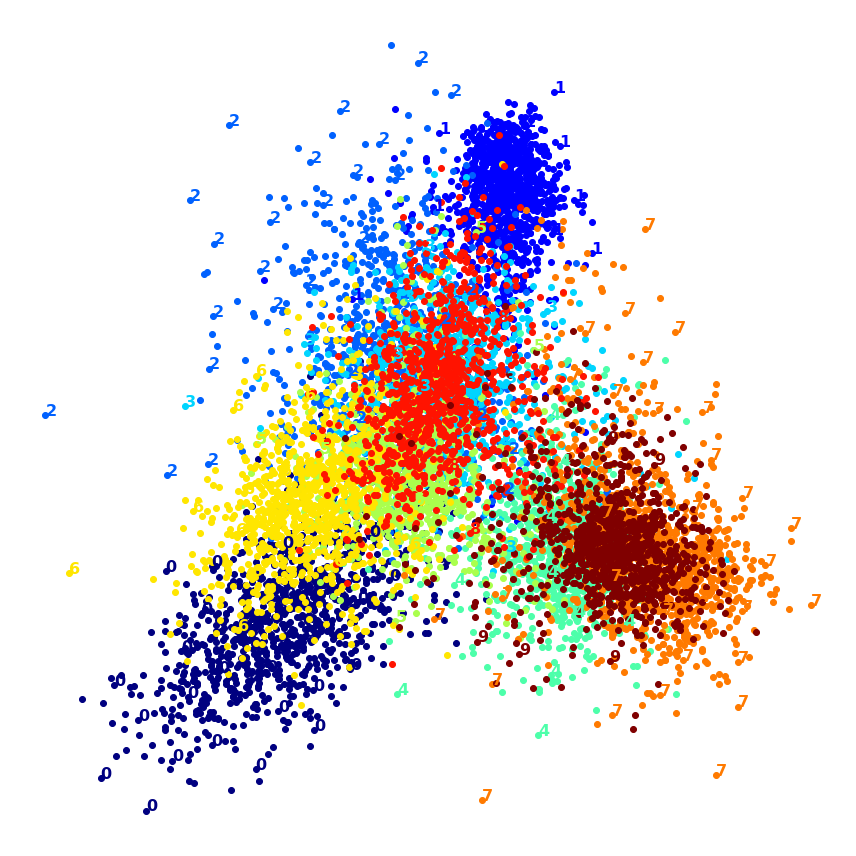

In [108]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

t0 = time.time()
X_lda_reduced = LinearDiscriminantAnalysis(n_components = 2).fit_transform(X, y)
t1 = time.time()
print(f'{t1 - t0:.1f} seconds')

fig, axes = plt.subplots(figsize = (12, 12))
plot_digits(axes, X_lda_reduced, y)
fig.tight_layout()
plt.show()

t-SNE wins in terms of separation for this dataset.
Let's time it.

33.5 seconds


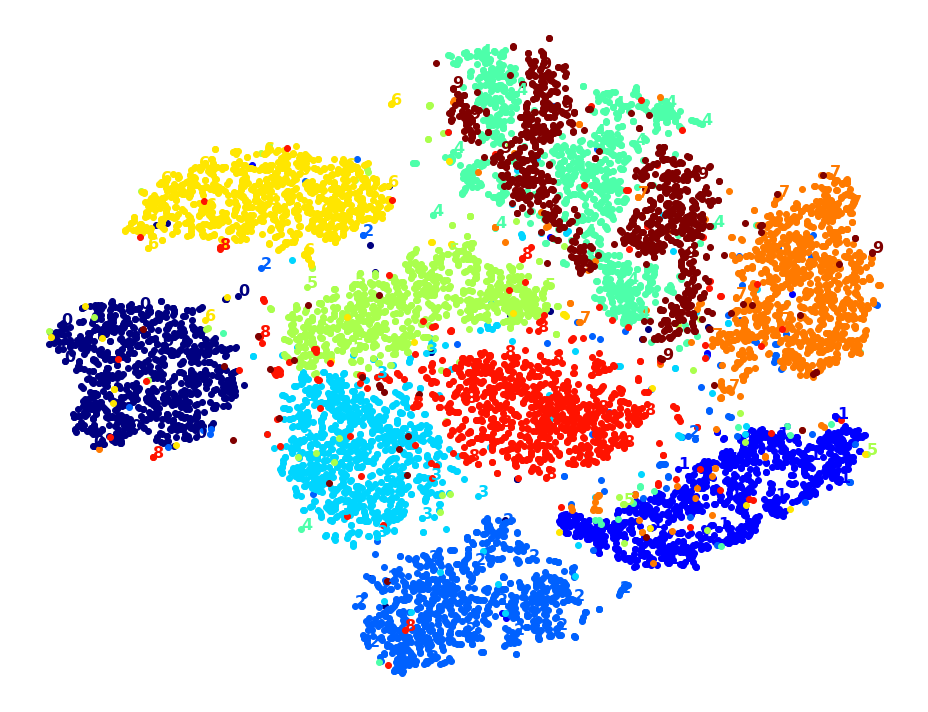

In [109]:
from sklearn.manifold import TSNE

t0 = time.time()
X_tsne_reduced = TSNE(n_components = 2, random_state = 42).fit_transform(X)
t1 = time.time()
print(f'{t1 - t0:.1f} seconds')

fig, axes = plt.subplots(figsize = (13, 10))
plot_digits(axes, X_tsne_reduced, y)
fig.tight_layout()
plt.show()

Separation is good.
In terms of timing, t-SNE is slower than LLE, and faster than MDS.

36.2 seconds


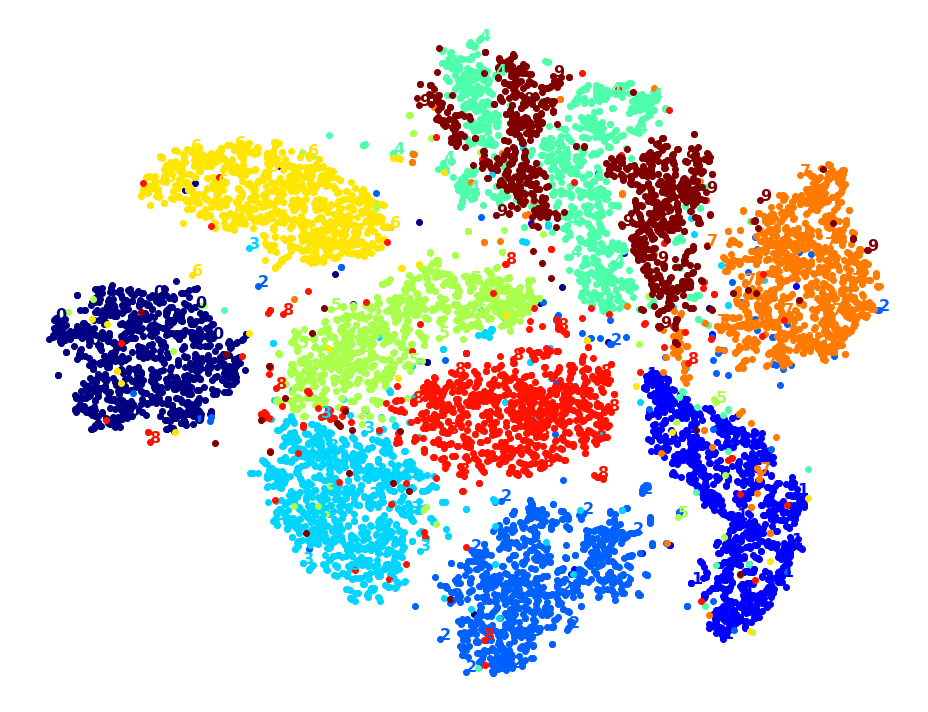

In [110]:
pca_tsne = Pipeline([
    ('pca', PCA(n_components = 0.95, random_state = 42)),
    ('tsne', TSNE(n_components = 2, random_state = 42))
])

t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X)
t1 = time.time()
print(f'{t1 - t0:.1f} seconds')

fig, axes = plt.subplots(figsize = (13, 10))
plot_digits(axes, X_pca_tsne_reduced, y)
fig.tight_layout()
plt.show()

Roughly the same result in terms of separation and speed.